# パーティクルフィルタによる自己位置推定

<IPython.core.display.Javascript object>


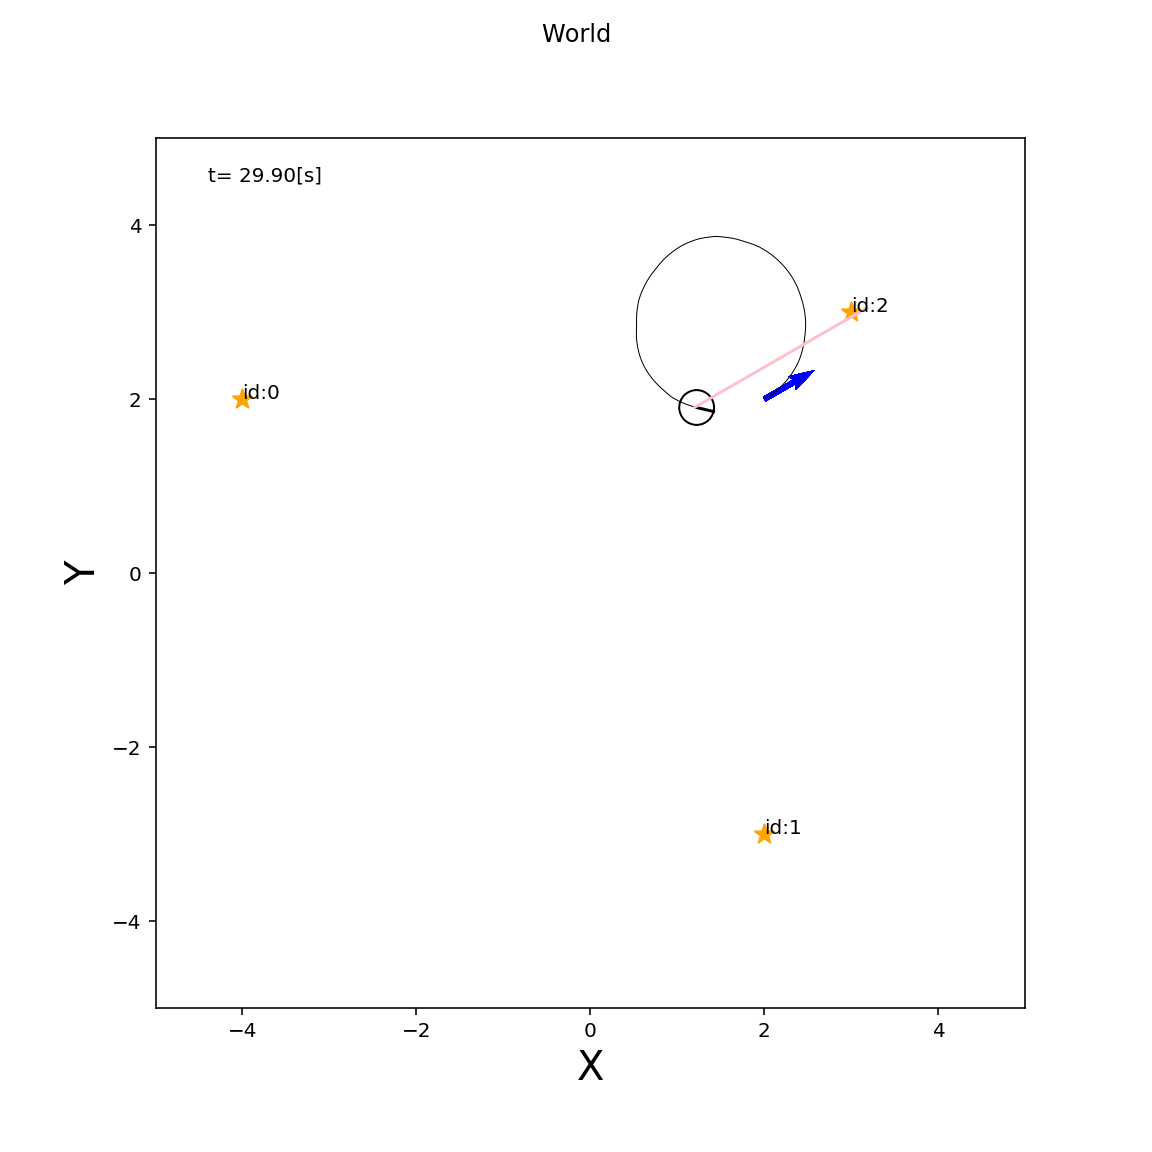

In [2]:
# 手始めにパーティクルを表示
import sys
sys.path.append('../src')
import importlib

import worlds
import maps
import numpy as np
import robots
import sensors
import agents
import landmarks
import estimators

def reload():
    importlib.reload(worlds)
    importlib.reload(maps)
    importlib.reload(robots)
    importlib.reload(sensors)
    importlib.reload(agents)
    importlib.reload(estimators)

reload()
    
world = worlds.World(30., 0.1, debuggable=False)
m = maps.Map()
for ln in [(-4., 2.), (2., -3), (3., 3.)]:
    m.append_landmark(landmarks.Point2DLandmark(*ln))
world.append(m)
    
initial_pose = np.array([2., 2., np.pi / 6.]).T
estimator = estimators.Mcl(initial_pose, 100)
circling = agents.EstimationAgent(
    0.2, 10./180.*np.pi, estimator=estimator)
r = robots.Robot(initial_pose, sensor=sensors.Camera(m), agent=circling)
world.append(r)
world.draw()